# Bayesian Multilevel Modelling using PyStan

This is a tutorial, following through Chris Fonnesbeck's [primer on using PyStan with Bayesian Multilevel Modelling](http://mc-stan.org/documentation/case-studies/radon.html).

# 4. An Unpooled Model

In [1]:
%pylab inline

import numpy as np
import pandas as pd
import pystan
import seaborn as sns

import clean_data

sns.set_context('notebook')

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "


## Building the model in `Stan`

We construct a model with no pooling, where we treat each county as having a prevailing radon level that is independent of all other counties: 

$$y_i = \alpha_{j[i]} + \beta x_i + \epsilon_i$$

* $y_i$: measured log(radon) in household $i$
* $\alpha_{j[i]}$: prevailing radon level in county $j[i]$, which is the county $j$ to which household $i$ belonds
* $\beta$: effect on measured log(radon) in moving from basement to ground floor measurement
* $\epsilon_i$: error in the model prediction for household %i%

### Specifying the unpooled model in Stan

For the unpooled model, we have the parameter $\alpha_{j[i]}$, representing a list of (independent) mean values, one for each county. Otherwise the model is the same as for the pooled example, with shared parameters for the effect of which floor is being measured, and the standard deviation of the error.

We construct the `data`, `parameters` and `model` blocks in a similar way to before. We define the number of samples (`N`, `int`), and two vectors of log-radon measurements (`y`, length `N`) and floor measurement covariates (`x`, length `N`). The main difference to before is that we define a list of counties (these are the indices 1..85 defined above, rather than county names), one for each sample:

In [2]:
unpooled_data = """
data {
  int<lower=0> N;
  int<lower=1, upper=85> county[N];
  vector[N] x;
  vector[N] y;
}
"""

We define three parameters: $\alpha_{j[i]}$ - one radon level per county (`a` - as a vector of length 85, one value per county); change in radon level by floor, $\beta$ (`beta`, a real value), and the Normal distribution scale parameter `sigma`, as before:

In [3]:
unpooled_parameters = """
parameters {
  vector[85] a;
  real beta;
  real<lower=0, upper=100> sigma;
}
"""

We also define a *transformed parameter*, for convenience. This defines a new variable $\hat{y}$ (`y_hat`, a `vector` with one value per sample) which is our estimate/prediction of log(radon) value per household. This could equally well be done in the model block - we don't *need* to generate a transformed parameter, but for more complex models this is a useful technique to improve readability and maintainability.

In [4]:
unpooled_transformed_parameters = """
transformed parameters {
  vector[N] y_hat;
  
  for (i in 1:N)
    y_hat[i] <- beta * x[i] + a[county[i]];
}
"""

Using this transformed parameter, the model form is now $y \sim N(\hat{y}, \sigma_e)$, making explicit that we are fitting parameters that result in the model *predicting* a household radon measurement, and we are estimating the error of this prediction against the observed values:

In [5]:
unpooled_model = """
model {
  y ~ normal(y_hat, sigma);
}
"""

## Running the unpooled model in `Stan`

We again map Python variables to those used in the `Stan` model, then pass the data, parameters (transformed and untransformed) and the model to `Stan`. We again specify 1000 iterations of 2 chains.

** Note that we have to offset our Python indices for counties by 1, as Python counts from zero, but `Stan` counts from 1. **

In [6]:
# Map data
unpooled_data_dict = {'N': len(clean_data.log_radon),
                      'county': clean_data.county + 1,  # Stan counts start from 1
                      'x': clean_data.floor_measure,
                      'y': clean_data.log_radon}

# Fit model
unpooled_fit = pystan.stan(model_code=unpooled_data + unpooled_parameters +
                                       unpooled_transformed_parameters + unpooled_model,
                            data=unpooled_data_dict,
                            iter=1000,
                            chains=2)

## Inspecting the fit

We can extract the sample from the fit for visualisation and summarisation. This time we do not use the `permuted=True` option. This returns a `StanFit4Model` object, from which we can extract the fitted estimates for a parameter using indexing, like a dictionary, e.g. `unpooled_fit['beta']`, and this will return a `numpy` `ndarray` of values. For $\alpha$ (`a`) we get a 1000x85 array, for $\beta$ (`beta`) we get a 1000x1 array. Mean and standard deviation (and other summary statistics) can be calculated from these.

When extracting vectors of $\alpha_{j[i]}$ (radon levels per county) and the associated standard errors, we use a `pd.Series` object, for compatibility with `pandas`. This allows us to specify an index, which is the list of county names in `clean.data.mn_counties`.

In [7]:
# Extract fit of radon by county
unpooled_estimates = pd.Series(unpooled_fit['a'].mean(0), index=clean_data.mn_counties)
unpooled_se = pd.Series(unpooled_fit['a'].std(0), index=clean_data.mn_counties)

# Inspect estimates
unpooled_estimates.head()

AITKIN      0.897083
ANOKA       0.931966
BECKER      1.541253
BELTRAMI    1.603539
BENTON      1.459515
dtype: float64

To inspect the variation in predicted radon levels at county resolution, we can plot the mean of each estimate with its associated standard error. To structure this visually, we'll reorder the counties such that we plot counties from lowest to highest.

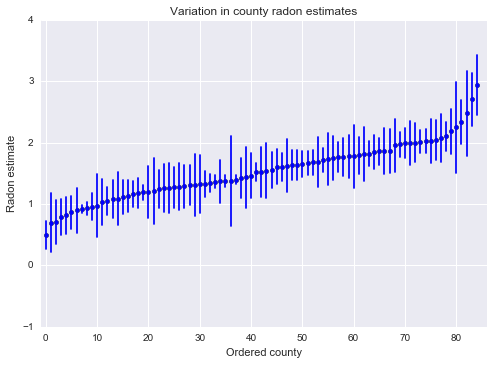

In [8]:
# Get row order of estimates as an index: low to high radon
order = unpooled_estimates.sort_values().index

# Plot mean radon estimates with stderr, following low to high radon order
plt.scatter(range(len(unpooled_estimates)), unpooled_estimates[order])
for i, m, se in zip(range(len(unpooled_estimates)),
                    unpooled_estimates[order],
                    unpooled_se[order]):
    plt.plot([i,i], [m - se, m + se], 'b-')
plt.xlim(-1, 86)
plt.ylim(-1, 4)
plt.title('Variation in county radon estimates')
plt.xlabel('Ordered county')
plt.ylabel('Radon estimate');

From this visual inspection, we can see that there is one county with a relatively low predicted radon level, and about five with relatively high levels. A single state-wide estimate of prevailing radon level could not represent this variation well, and this reinforces our suspicion that a pooled estimate is likely to exhibit significant *bias*.